In [1]:
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

sys.path.append('../')

### Load training data

In [2]:
from src.classifiers.dataset import get_X_y

train_val_test_dir = os.path.abspath("../data/affinity_data/example/")

train = pd.read_csv(os.path.join(train_val_test_dir, "train.csv"))
val = pd.read_csv(os.path.join(train_val_test_dir, "val.csv"))
test = pd.read_csv(os.path.join(train_val_test_dir, "test.csv"))

# this takes ~1 min to load large (500k seqs) datasets
X_train, y_train = get_X_y(train)
X_val,   y_val   = get_X_y(val)

train.head()

,seq,class,label,edit_distance
0,YTTSASYDYT,low,0,9
1,WANTLSVHIR,high,1,9
2,YALDRMYAFD,high,1,6
3,FDLVGFYANG,mid,0,6
4,YTAPSSYSLI,high,1,9


### Train

In [3]:
from src.classifiers.cnn.train import (
    fit_CNN,
    plot_loss
)

epochs = 100
patience = 5
batch_size = 32
input_shape = (X_train.shape[1], X_train.shape[2])

CNN, history = fit_CNN(
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=epochs,
    verbose=1,  # 1 = show progress bar
    batch_size=batch_size,
    input_shape=input_shape,
    patience=patience
    )

2024-01-10 11:07:51.131171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 11:07:51.131248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 11:07:51.206102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 11:07:51.543778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 11:07:57.204522: W tensorflow/compiler/tf2

Epoch 1/100
18/18 [==============================] - 2s 26ms/step - loss: 0.6407 - accuracy: 0.6696 - val_loss: 0.6139 - val_accuracy: 0.6750
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 0.6006 - accuracy: 0.6714 - val_loss: 0.5920 - val_accuracy: 0.6750
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 0.5715 - accuracy: 0.6750 - val_loss: 0.5689 - val_accuracy: 0.7083
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.5426 - accuracy: 0.7286 - val_loss: 0.5424 - val_accuracy: 0.7500
Epoch 5/100
18/18 [==============================] - 0s 13ms/step - loss: 0.5049 - accuracy: 0.7768 - val_loss: 0.5225 - val_accuracy: 0.7417
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.4750 - accuracy: 0.7804 - val_loss: 0.5033 - val_accuracy: 0.7500
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 0.4466 - accuracy: 0.8179 - val_loss: 0.4912 - val_accuracy: 0.7833
Epoch 

In [4]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 400)           40400     
                                                                 
 dropout (Dropout)           (None, 10, 400)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 400)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 300)               1080300   
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                        

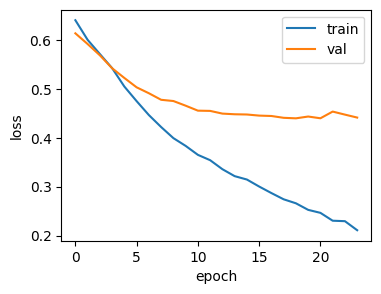

In [5]:
plot_loss(history)

### Evaluate

In [6]:
from src.classifiers.evaluate import (
    get_metrics,
    plot_predictions_histogram,
    plot_PR_AUC,
    plot_PR_AUC_by_edit_distance,
    plot_predictions_histogram_stack_editdist
)
from src.plotting import buzz_colours

# trim for speed of testing when test set is large
df_evaluate = test[:10000]
X_evaluate,  y_evaluate  = get_X_y(df_evaluate)

predictions = CNN.predict(X_evaluate)
df_evaluate["predictions"] = predictions
get_metrics(y_evaluate, predictions)

157/157 [==============================] - 1s 3ms/step


,PR AUC,F-score,MCC,ROC AUC,Balanced Accuracy,Youden cutoff
0,0.801,0.713,0.566,0.875,0.796,0.33


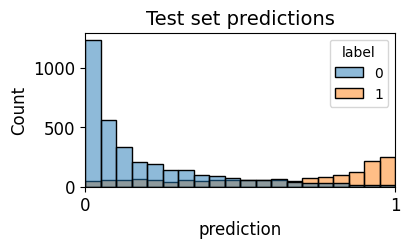

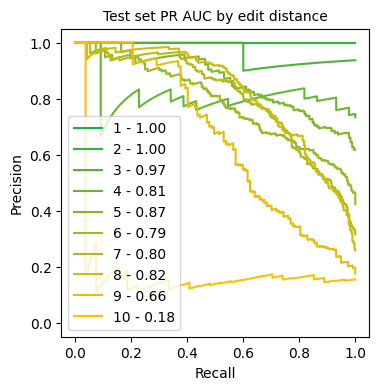

In [7]:
buzz_cols = buzz_colours()
c1 = buzz_cols["dark_green"]
c2 = buzz_cols["yellowy_gold"]
colour_start_end = (c1,c2)

plot_predictions_histogram(y_evaluate, predictions, title="Test set predictions")
plot_PR_AUC_by_edit_distance(y_evaluate, predictions, df_evaluate, colour_start_end=colour_start_end, title="Test set PR AUC by edit distance")

### Save

In [8]:
cnn_weights_file = os.path.join(train_val_test_dir, "cnn_weights.h5")
CNN.save(cnn_weights_file)

/data/localhost/chinery/Tz_her2_affinity_and_beyond/.buzz_venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
